<a href="https://colab.research.google.com/github/MaxiStahl1992/rl-pong/blob/main/RL_Pong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install necessary libraries

In [1]:
!apt install swig cmake
!pip install -r https://raw.githubusercontent.com/huggingface/deep-rl-class/main/notebooks/unit1/requirements-unit1.txt
!pip install gymnasium[atari]
!pip install stable_baselines3
!pip install ale-py
!sudo apt-get update
!sudo apt-get install -y python3-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay
# Install required packages with ROM license acceptance
!pip install "gymnasium[accept-rom-license]"
!pip install "autorom[accept-rom-license]"

# Use AutoROM to install the Atari ROMs
!AutoROM --accept-license

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 0s (3,462 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 123605 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubu

The notebook needs to be restarted to ensure the virtual display will work.

In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:
# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

# Imports

In [3]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
from collections import deque

from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.atari_wrappers import AtariWrapper
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback

from huggingface_sb3 import push_to_hub, package_to_hub
from huggingface_hub import notebook_login, HfApi

import torch
import torch.nn as nn
import torch.optim as optim

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


# Set Seed

In [4]:
seed = 73
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# Set device to GPU if available

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Set General Environment Params

In [6]:
num_envs = 8
env_id = "ALE/Pong-v5"

In [7]:
print(gym.envs.registry.get(env_id))

EnvSpec(id='ALE/Pong-v5', entry_point='shimmy.atari_env:AtariEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=None, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'game': 'pong', 'obs_type': 'rgb', 'repeat_action_probability': 0.25, 'full_action_space': False, 'frameskip': 4, 'max_num_frames_per_episode': 108000}, namespace='ALE', name='Pong', version=5, additional_wrappers=(), vector_entry_point=None)


# Stable Baselines Implementation

## PPO and A2C Implementation

### Create Vectorized Environments for PPO and A2C

In [25]:
def make_env(env_id, seed):
  def _init():
    env = gym.make(env_id)
    env = AtariWrapper(env, clip_reward=True)
    env = Monitor(env)
    env.seed(seed)
    env.action_space.seed(seed)
    return env
  return _init

envs = DummyVecEnv([make_env(env_id, seed + i) for i in range(num_envs)])

### Create Evaluation Environment for PPO and A2C

In [26]:
eval_env = gym.make(env_id)
eval_env = AtariWrapper(eval_env, clip_reward=False)
eval_env = Monitor(eval_env)
eval_env.reset(seed=seed)
eval_env.action_space.seed(seed)

[73]

### Training Function with Reward Callback

In [27]:
class RewardCallback(BaseCallback):
  def __init__(self):
    super(RewardCallback, self).__init__()
    self.rewards = []

  def _on_step(self):
    if 'infos' in self.locals:
      infos = self.locals['infos']
      for info in infos:
        if 'episode' in info:
          self.rewards.append(info['episode']['r'])
    return True

In [28]:
def train_and_evaluate(model_class, envs, eval_env, total_timesteps=2000000, seed=73):
  callback = RewardCallback()
  start_time = time.time()
  model = model_class("CnnPolicy", envs, verbose=1, seed=seed, device=device)
  model.learn(total_timesteps=total_timesteps, callback=callback)
  training_time = time.time() - start_time
  mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10)
  return model, mean_reward, std_reward, training_time, callback.rewards

### Train PPO

In [ ]:
ppo_model, ppo_mean_reward, ppo_std_reward, ppo_training_time, ppo_rewards = train_and_evaluate(PPO, envs, eval_env)

Using cpu device
Wrapping the env in a VecTransposeImage.
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 215         |
|    ep_rew_mean          | -20.6       |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 2           |
|    time_elapsed         | 471         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.010019276 |
|    clip_fraction        | 0.0778      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.78       |
|    explained_variance   | -0.000107   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0737      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00417    |
|    value_loss           | 0.207       |
-----------------------------------------
------------------------------------------
| rollout/       

### Train A2C

In [ ]:
a2c_model, a2c_mean_reward, a2c_std_reward, a2c_training_time, a2c_rewards = train_and_evaluate(A2C, envs, eval_env)

## DQN Implementation

### Create DQN Environment

In [ ]:
def make_dqn_env(env_id, seed):
  env = gym.make(env_id)
  env = AtariWrapper(env, clip_reward=True)
  env = Monitor(env)
  env.reset(seed=seed)
  env.action_space.seed(seed)
  return env

dqn_env = make_dqn_env(env_id, seed)

### Create DQN Evaluation Environment

In [ ]:
eval_env_dqn = gym.make(env_id)
eval_env_dqn = AtariWrapper(eval_env_dqn, clip_reward=False)
eval_env_dqn = Monitor(eval_env_dqn)
eval_env_dqn.reset(seed=seed)
eval_env_dqn.action_space.seed(seed)

### Training Function

In [ ]:
def train_and_evaluate_dqn(env, eval_env, total_timesteps=2000000, seed=73):
  callback = RewardCallback()
  start_time = time.time()
  model = DQN(
      "CnnPolicy",
      env,
      verbose=1,
      seed=seed,
      device = device,
      buffer_size = 100000,
      learning_starts = 50000,
      target_update_interval = 10000,
      train_freq = 4,
      exploration_fraction = 0.1,
      exploration_final_eps = 0.01
      )
  model.learn(total_timesteps=total_timesteps, callback=callback)
  training_time = time.time() - start_time
  mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10)
  return model, mean_reward, std_reward, training_time, callback.rewards

### Train DQN

In [ ]:
dqn_model, dqn_mean_reward, dqn_std_reward, dqn_training_time, dqn_rewards = train_and_evaluate_dqn(dqn_env, eval_env_dqn)

## Compare Models

In [ ]:
data = {
    'Model': ['PPO', 'A2C', 'DQN'],
    'Mean Reward': [ppo_mean_reward, a2c_mean_reward, dqn_mean_reward],
    'Std Reward': [ppo_std_reward, a2c_std_reward, dqn_std_reward],
    'Training Time (s)': [ppo_training_time, a2c_training_time, dqn_training_time],
    'Total Steps': [ppo_model.num_timesteps, a2c_model.num_timesteps, dqn_model.num_timesteps]
}

df = pd.DataFrame(data)
df

### Visualize Training Rewards

In [ ]:
def plot_rewards(rewards, algorithm_name):
  plt.figure(figsize=(12, 6))
  plt.plot(rewards)
  plt.xlabel('Episodes')
  plt.ylabel('Reward')
  plt.title(f'{algorithm_name} Training Rewards')
  plt.show()

In [ ]:
plot_rewards(ppo_rewards, 'PPO')
plot_rewards(a2c_rewards, 'A2C')
plot_rewards(dqn_rewards, 'DQN')

## Push Models to Huggingface

In [ ]:
notebook_login()

In [ ]:
def push_model_to_hf(model, model_name, model_architecture, env_id, repo_id, used_eval_env, commit_message):
  repo_id = repo_id
  model.save(repo_id)
  package_to_hub(model=model,
               model_name=model_name,
               model_architecture=model_architecture,
               env_id=env_id,
               eval_env=used_eval_env,
               repo_id=repo_id,
               commit_message=commit_message)

In [ ]:
push_model_to_hf(ppo_model, "ppo", "PPO", env_id, "maxstahl/ppo-Pongv5", eval_env, "PPO Training")
push_model_to_hf(a2c_model, "a2c", "A2C", env_id, "maxstahl/a2c-pongv5", eval_env, "A2C Training")
push_model_to_hf(dqn_model, "dqn", "DQN", env_id, "maxstahl/dqn-pongv5", eval_env_dqn, "DQN Training")

# Environment for Simple Implementations

In [8]:
env_simple = gym.make(env_id, frameskip=1)
env_simple = gym.wrappers.AtariPreprocessing(env_simple, scale_obs=True)
env_simple = gym.wrappers.FrameStack(env_simple, num_stack=4)

# PPO Implementation

## Define PPO Network

In [9]:
class PPONetwork(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(PPONetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        # Calculate the size of the linear input
        def conv2d_size_out(size, kernel_size, stride):
            return (size - (kernel_size - 1) - 1) // stride + 1

        conv_w = input_shape[1]
        conv_h = input_shape[2]
        for conv_layer in self.conv:
            if isinstance(conv_layer, nn.Conv2d):
                conv_w = conv2d_size_out(conv_w, conv_layer.kernel_size[0], conv_layer.stride[0])
                conv_h = conv2d_size_out(conv_h, conv_layer.kernel_size[1], conv_layer.stride[1])

        linear_input_size = conv_w * conv_h * 64

        self.fc = nn.Linear(linear_input_size, 512)
        self.policy_head = nn.Linear(512, n_actions)
        self.value_head = nn.Linear(512, 1)

    def forward(self, x):
        x = x / 255.0  # Normalize pixel values
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc(x))
        policy_logits = self.policy_head(x)
        value = self.value_head(x)
        return policy_logits, value

## PPO Buffer

In [10]:
class PPOBuffer:
    def __init__(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.values = []
        self.dones = []

    def clear(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.values = []
        self.dones = []

## Hyperparameters

In [11]:
gamma = 0.99
lambda_gae = 0.95
clip_epsilon = 0.1
ppo_epochs = 4
mini_batch_size = 64
entropy_coef = 0.01
value_loss_coef = 0.5
max_grad_norm = 0.5
learning_rate = 2.5e-4

## Calculate Advantage and Returns

In [12]:
def compute_gae(rewards, values, dones, next_value, gamma=0.99, lambda_=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * (1 - dones[step]) - values[step]
        gae = delta + gamma * lambda_ * (1 - dones[step]) * gae
        returns.insert(0, gae + values[step])
    advantages = [ret - val for ret, val in zip(returns, values[:-1])]
    return returns, advantages

## Training Loop

In [15]:
def train_ppo(env, num_steps, device):
    n_actions = env.action_space.n
    state_shape = env.observation_space.shape  # (84, 84, 4)

    model = PPONetwork(state_shape, n_actions).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize variables
    buffer = PPOBuffer()
    episode_rewards = []
    total_steps = 0
    start_time = time.time()
    num_env_steps = num_steps
    rollout_length = 2048  # Number of steps to collect before updating
    state, _ = env.reset()
    state = np.array(state)
    state = torch.tensor(state, device=device).unsqueeze(0).float()
    episode_reward = 0
    episode = 0

    while total_steps < num_env_steps:
        for _ in range(rollout_length):
            with torch.no_grad():
                logits, value = model(state)
                probs = nn.functional.softmax(logits, dim=-1)
                dist = torch.distributions.Categorical(probs)
                action = dist.sample()
                log_prob = dist.log_prob(action)
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            episode_reward += reward

            # Store data in buffer
            buffer.states.append(state)
            buffer.actions.append(action)
            buffer.log_probs.append(log_prob)
            buffer.values.append(value)
            buffer.rewards.append(torch.tensor([reward], device=device))
            buffer.dones.append(torch.tensor([done], device=device, dtype=torch.float))

            state = np.array(next_state)

            state = torch.tensor(state, device=device).unsqueeze(0).float()
            total_steps += 1

            if done:
                episode += 1
                episode_rewards.append(episode_reward)
                episode_reward = 0
                state, _ = env.reset()
                state = np.array(state)
                state = torch.tensor(state, device=device).unsqueeze(0).float()

        # Compute returns and advantages
        with torch.no_grad():
            _, next_value = model(state)
        returns, advantages = compute_gae(
            [r.item() for r in buffer.rewards],
            [v.item() for v in buffer.values],
            [d.item() for d in buffer.dones],
            next_value.item(),
            gamma,
            lambda_gae
        )
        returns = torch.tensor(returns, device=device).unsqueeze(1)
        advantages = torch.tensor(advantages, device=device).unsqueeze(1)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Flatten buffers
        states = torch.cat(buffer.states)
        actions = torch.cat(buffer.actions).unsqueeze(1)
        old_log_probs = torch.cat(buffer.log_probs).detach()
        values = torch.cat(buffer.values).detach()

        # PPO Update
        for _ in range(ppo_epochs):
            idx = np.random.permutation(len(states))
            for i in range(0, len(states), mini_batch_size):
                ind = idx[i:i + mini_batch_size]
                batch_states = states[ind]
                batch_actions = actions[ind]
                batch_old_log_probs = old_log_probs[ind]
                batch_returns = returns[ind]
                batch_advantages = advantages[ind]

                logits, value = model(batch_states)
                probs = nn.functional.softmax(logits, dim=-1)
                dist = torch.distributions.Categorical(probs)
                entropy = dist.entropy().mean()
                new_log_probs = dist.log_prob(batch_actions.squeeze())

                ratio = torch.exp(new_log_probs - batch_old_log_probs)
                surr1 = ratio * batch_advantages.squeeze()
                surr2 = torch.clamp(ratio, 1.0 - clip_epsilon, 1.0 + clip_epsilon) * batch_advantages.squeeze()
                policy_loss = -torch.min(surr1, surr2).mean()
                value_loss = nn.functional.mse_loss(value.squeeze(), batch_returns.squeeze())
                loss = policy_loss + value_loss_coef * value_loss - entropy_coef * entropy

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

        buffer.clear()

        if episode % 10 == 0 and episode > 0:
            mean_reward = np.mean(episode_rewards[-10:])
            print(f"Total Steps: {total_steps}, Episode: {episode}, Mean Reward: {mean_reward:.2f}")

    total_training_time = time.time() - start_time
    env.close()
    print("Training complete!")
    print(f"Total training time: {total_training_time:.2f} seconds")
    return model, episode_rewards, total_training_time

## Train the Model

In [17]:
num_episodes = 100
ppo_simple_model, ppo_simple_episode_rewards, ppo_simple_training_time = train_ppo(env_simple, num_steps=num_episodes, device=device)

Training complete!
Total training time: 40.02 seconds


## Save and Upload the model to Huggingface

In [ ]:
torch.save(ppo_model.state_dict(), 'simple_ppo_pong.pth')

In [ ]:
api = HfApi()
api.upload_file(
    path_or_fileobj='simple_ppo_pong.pth',
    path_in_repo='simple_ppo_pong.pth',
    repo_id='your_username/simple-ppo-pong',  # Replace with your username
    repo_type='model',
    commit_message='Upload simple PPO model'
)

# A2C Implementation


*   Actor-Critic Architecture
*   Advantage estimation
*   On-policy updates




## Define the A2C Network

In [19]:
class ActorCritic(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(ActorCritic, self).__init__()
        print(f"Input shape: {input_shape}")
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        # Calculate the size of the linear input
        def conv2d_size_out(size, kernel_size, stride):
            return (size - (kernel_size - 1) - 1) // stride + 1

        conv_w = conv2d_size_out(conv2d_size_out(conv2d_size_out(input_shape[1], 8, 4), 4, 2), 3, 1)
        conv_h = conv2d_size_out(conv2d_size_out(conv2d_size_out(input_shape[2], 8, 4), 4, 2), 3, 1)
        linear_input_size = conv_w * conv_h * 64

        self.fc = nn.Linear(linear_input_size, 512)
        self.actor = nn.Linear(512, n_actions)
        self.critic = nn.Linear(512, 1)

    def forward(self, x):
        x = x / 255.0
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc(x))
        logits = self.actor(x)
        value = self.critic(x)
        return logits, value

## Training Loop

In [22]:
def train_a2c(env, num_episodes, device):
    n_actions = env.action_space.n
    state_shape = env.observation_space.shape
    print(f"Input shape: {state_shape}")  # Should print (4, 84, 84)

    model = ActorCritic(state_shape, n_actions).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Hyperparameters
    gamma = 0.99
    entropy_coef = 0.01
    value_loss_coef = 0.5
    max_grad_norm = 0.5
    losses = []
    start_time = time.time()
    episode_rewards = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        state = np.array(state)
        state = torch.tensor(state, device=device).unsqueeze(0).float()
        episode_reward = 0  # Initialize episode reward

        log_probs = []
        values = []
        rewards = []
        entropies = []
        dones = []

        done = False
        while not done:
            # Forward pass
            logits, value = model(state)
            probs = nn.functional.softmax(logits, dim=-1)
            log_prob = nn.functional.log_softmax(logits, dim=-1)
            entropy = -(log_prob * probs).sum(1, keepdim=True)
            action = probs.multinomial(num_samples=1)

            # Take action in the environment
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            episode_reward += reward

            # Convert next_state to tensor
            next_state_tensor = torch.tensor(next_state, device=device).unsqueeze(0).float()

            # Store transition data
            rewards.append(torch.tensor([reward], device=device))
            log_probs.append(log_prob.gather(1, action))
            values.append(value)
            entropies.append(entropy)
            dones.append(torch.tensor([done], device=device, dtype=torch.float))

            # Move to the next state
            state = next_state_tensor

        # Compute returns and advantages after the episode ends
        with torch.no_grad():
            next_value = torch.zeros(1, 1, device=device)  # Since the episode ended

        returns = []
        R = next_value
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)

        returns = torch.cat(returns).detach()
        log_probs = torch.cat(log_probs)
        values = torch.cat(values).squeeze()
        entropies = torch.cat(entropies).squeeze()
        advantage = returns - values

        # Loss calculation
        value_loss = advantage.pow(2).mean()
        policy_loss = -(log_probs * advantage.detach()).mean()
        entropy_loss = entropies.mean()

        loss = policy_loss + value_loss_coef * value_loss - entropy_coef * entropy_loss
        losses.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        episode_rewards.append(episode_reward)
        if episode % 10 == 0:
          mean_reward = np.mean(episode_rewards[-10:])
          print(f"Episode {episode + 1}/{num_episodes}, Mean Reward: {mean_reward}")

        # Optionally, you can log the loss or other metrics here

    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f} seconds")

    env.close()
    print("Training complete!")

    return model, episode_rewards, training_time

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Train the Model

In [23]:
num_steps = 100
a2c_simple_model, a2c_simple_episode_rewards, a2c_simple_training_time = train_a2c(env_simple, num_steps, device)

Input shape: (4, 84, 84)
Input shape: (4, 84, 84)
Episode 1/100, Mean Reward: -21.0
Episode 11/100, Mean Reward: -20.1
Episode 21/100, Mean Reward: -20.8
Episode 31/100, Mean Reward: -20.1
Episode 41/100, Mean Reward: -20.2
Episode 51/100, Mean Reward: -20.5
Episode 61/100, Mean Reward: -20.2
Episode 71/100, Mean Reward: -20.2
Episode 81/100, Mean Reward: -20.4
Episode 91/100, Mean Reward: -20.0
Training time: 1612.94 seconds
Training complete!


## Save and Upload the Model to Huggingface

In [ ]:
# Save the model
torch.save(a2c_model.state_dict(), 'simple_a2c_pong.pth')

In [ ]:
# Upload to Hugging Face
api.upload_file(
    path_or_fileobj='simple_a2c_pong.pth',
    path_in_repo='simple_a2c_pong.pth',
    repo_id='your_username/simple-a2c-pong',  # Replace with your username
    repo_type='model',
    commit_message='Upload simple A2C model'
)

# DQN Implementation



*   Q-Learning with a neural network to approximate the Q function
*   Experience replay buffer
*   Use of target network to stabilize training






## Define the Q-Network

In [24]:
class DQNNetwork(nn.Module):
  def __init__(self, input_shape, n_actions):
    super(DQNNetwork, self).__init__()
    print(f"Input shape: {input_shape}")
    self.conv = nn.Sequential(
        nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=4, stride=2),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1),
        nn.ReLU()
    )

    # Calculate the size of the linear input
    def conv2d_size_out(size, kernel_size, stride):
      return (size - (kernel_size - 1) - 1) // stride + 1

    conv_w = conv2d_size_out(conv2d_size_out(conv2d_size_out(input_shape[1], 8, 4), 4, 2), 3, 1)
    conv_h = conv2d_size_out(conv2d_size_out(conv2d_size_out(input_shape[2], 8, 4), 4, 2), 3, 1)
    linear_input_size = conv_w * conv_h * 64

    self.fc = nn.Sequential(
        nn.Linear(linear_input_size, 512),
        nn.ReLU(),
        nn.Linear(512, n_actions)
    )

  def forward(self, x):
    x = x / 255.0                 # normalize pixel values
    x = self.conv(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

## Experience Replay Buffer

In [25]:
class ReplayBuffer:
  def __init__(self, capacity):
    self.capacity = capacity
    self.buffer = []
    self.position = 0

  def push(self, state, action, reward, next_state, done):
    """ save a transition """
    if len(self.buffer) < self.capacity:
      self.buffer.append(None)
    self.buffer[self.position] = (state, action, reward, next_state, done)
    self.position = (self.position + 1) % self.capacity

  def sample(self, batch_size):
    """ sample a batch of transitions """
    batch = random.sample(self.buffer, batch_size)
    state, action, reward, next_state, done = map(np.stack, zip(*batch))
    return state, action, reward, next_state, done

  def __len__(self):
    return len(self.buffer)

## Epsilon-Greedy Action Selection

In [26]:
def select_action(state, epsilon, n_actions, policy_net, device):
  if random.random() > epsilon:
    with torch.no_grad():
      state = torch.tensor(state, device=device).unsqueeze(0)
      q_values = policy_net(state)
      action = q_values.argmax().item()
  else:
    action = random.randrange(n_actions)
  return action

# Training Loop

In [27]:
def train_dqn(env, num_episodes, device):
  n_actions = env.action_space.n
  state_shape = env.observation_space.shape

  policy_net = DQNNetwork(state_shape, n_actions).to(device)
  target_net = DQNNetwork(state_shape, n_actions).to(device)
  target_net.load_state_dict(policy_net.state_dict())
  target_net.eval()

  optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
  replay_buffer = ReplayBuffer(capacity=100000)
  batch_size = 32
  gamma = 0.99
  epsilon_start = 1.0
  epsilon_end = 0.01
  epsilon_decay = 500000
  target_update_interval = 1000
  total_steps = 0
  start_time = time.time()
  losses = []
  episode_rewards = []

  for episode in range(num_episodes):
    state, _ = env.reset()

    episode_reward = 0
    done = False

    while not done:
      epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * total_steps / epsilon_decay)
      action = select_action(state, epsilon, n_actions, policy_net, device)
      next_state, reward, terminated, truncated, _ = env.step(action)

      done = terminated or truncated

      replay_buffer.push(state, action, reward, next_state, done)

      state = next_state
      episode_reward += reward
      total_steps += 1

      # Training step
      if len(replay_buffer) > batch_size and total_steps > 50000:
        states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        next_states = np.array(next_states)
        dones = np.array(dones)

        states = torch.tensor(states, device=device, dtype=torch.float32)
        actions = torch.tensor(actions, device=device, dtype=torch.int64).unsqueeze(1)
        rewards = torch.tensor(rewards, device=device, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(next_states, device=device, dtype=torch.float32)
        dones = torch.tensor(dones, device=device, dtype=torch.float32).unsqueeze(1)

        # Compute Q-Values
        q_values = policy_net(states).gather(1, actions)

        with torch.no_grad():
          max_next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)
          expected_q_values = rewards + (gamma * max_next_q_values * (1 - dones.type(torch.float32)))

        loss = nn.functional.mse_loss(q_values, expected_q_values)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      # Update the target network
      if total_steps % target_update_interval == 0:
        target_net.load_state_dict(policy_net.state_dict())

    episode_rewards.append(episode_reward)
    if episode % 10 == 0:
      mean_reward = np.mean(episode_rewards[-10:])
      print(f"Episode {episode + 1}/{num_episodes}, Mean Reward: {mean_reward}, Epsilon: {epsilon:.2f}")

  end_time = time.time()
  training_time = end_time - start_time
  print(f"Training time: {training_time:.2f} seconds")

  env.close()
  print("Training complete!")

  return policy_net, episode_rewards, training_time


## Train the Model

In [ ]:
num_episodes = 100
dqn_simple_policy_net, dqn_simple_episode_rewards, dqn_simple_training_time = train_dqn(env_simple, num_episodes, device)

Input shape: (4, 84, 84)
Input shape: (4, 84, 84)
Episode 1/100, Mean Reward: -21.0, Epsilon: 1.00
Episode 11/100, Mean Reward: -20.3, Epsilon: 0.98
Episode 21/100, Mean Reward: -20.2, Epsilon: 0.96
Episode 31/100, Mean Reward: -20.6, Epsilon: 0.94
Episode 41/100, Mean Reward: -20.4, Epsilon: 0.93
Episode 51/100, Mean Reward: -20.5, Epsilon: 0.91


# Save and Upload the Model to Huggingface

In [50]:
torch.save(dqn_simple_policy_net.state_dict(), "simple_dqn_model.pth")

In [ ]:
notebook_login()

In [ ]:
# Upload to Hugging Face
api = HfApi()
api.upload_file(
    path_or_fileobj='simple_dqn_pong.pth',
    path_in_repo='simple_dqn_pong.pth',
    repo_id='your_username/simple-dqn-pong',  # Replace with your username
    repo_type='model',
    commit_message='Upload simple DQN model'
)

# Model Comparison

## Summary Table

In [18]:
data = {
    'Algorithm': ['DQN', 'A2C', 'PPO'],
    'Mean Reward': [np.mean(dqn_simple_episode_rewards[-10:]), np.mean(a2c_simple_episode_rewards[-10:]), np.mean(ppo_simple_episode_rewards[-10:])],
    'Std Reward': [np.std(dqn_simple_episode_rewards[-10:]), np.std(a2c_simple_episode_rewards[-10:]), np.std(ppo_simple_episode_rewards[-10:])],
    'Training Time (s)': [dqn_simple_training_time, a2c_simple_training_time, ppo_simple_training_time]
}

print(a2c_simple_episode_rewards[-10:])

df = pd.DataFrame(data)
print(df)

NameError: name 'dqn_simple_episode_rewards' is not defined

## Training Reward Visualization

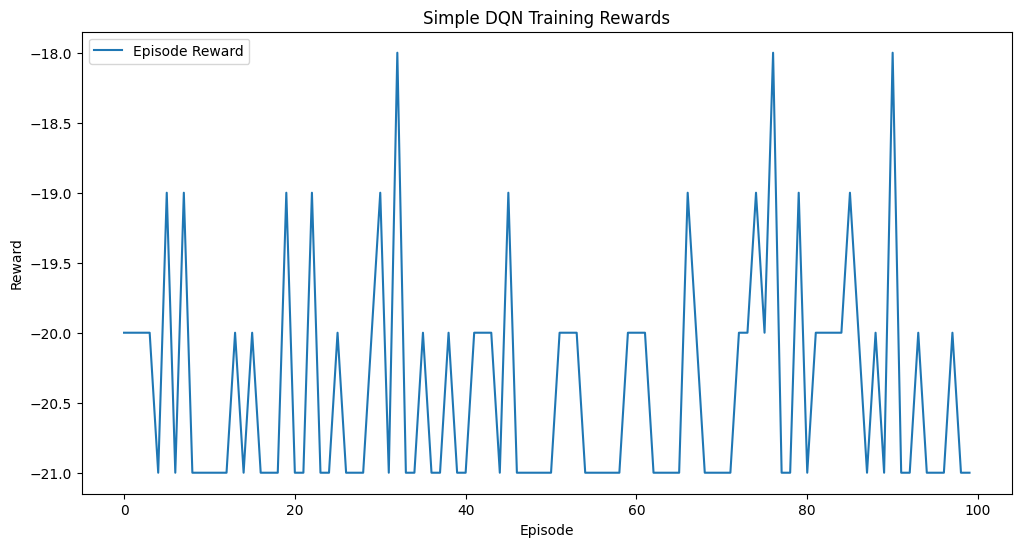

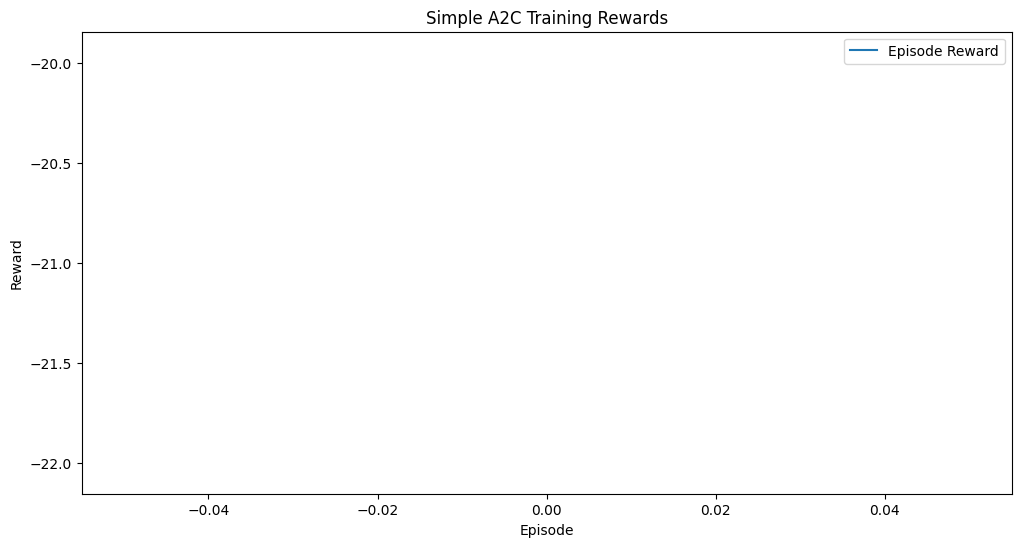

In [61]:
def plot_rewards(rewards, algorithm_name):
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label='Episode Reward')
    plt.title(f"{algorithm_name} Training Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.show()

# Plotting the rewards
plot_rewards(dqn_simple_episode_rewards, "Simple DQN")
plot_rewards(a2c_simple_episode_rewards, "Simple A2C")

In [ ]:
def plot_smoothed_rewards(rewards, algorithm_name, window=10):
    smoothed_rewards = np.convolve(rewards, np.ones(window)/window, mode='valid')
    plt.figure(figsize=(12, 6))
    plt.plot(smoothed_rewards, label=f'Smoothed Reward (window={window})', color='orange')
    plt.title(f"{algorithm_name} Smoothed Training Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Smoothed Reward")
    plt.legend()
    plt.show()

In [ ]:
def plot_loss(losses, algorithm_name):
    plt.figure(figsize=(12, 6))
    plt.plot(losses, label='Loss')
    plt.title(f"{algorithm_name} Training Loss")
    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()